<img src="./img/DSME_logo.png" alt="Scoring probabilities for direct shots [2]" width="1000">

#  Reinforcement Learning and Learning-based Control

<p style="font-size:12pt";> 
<b> Prof. Dr. Sebastian Trimpe, Dr. Friedrich Solowjow </b><br>
<b> Institute for Data Science in Mechanical Engineering (DSME) </b><br>
<a href = "mailto:rllbc@dsme.rwth-aachen.de">rllbc@dsme.rwth-aachen.de</a><br>
</p>

---

# Bonus Point Assignment 1 - Task 3: Off-Policy MC with Weighted Importance Sampling

*Important: Place your answer in fields marked for this purpose and do not modify any of the cells. In case anything outside the answer fields has been modified, we recommend restarting the notebook.*

## Library Imports

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import defaultdict
import math
import numpy as np
import custom_envs
from render_util import plot_action_value
from matplotlib.animation import FuncAnimation
%matplotlib inline
from IPython.display import Video
from IPython.display import display
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## Task Description

With Q-learning, we've seen an off-policy TD method. Off-policy methods can be helpful because they allow for the reuse of data. But how can we implement this concept for Monte Carlo (MC) methods, where we consider complete rollouts rather than individual transitions? First, it requires the introduction of two different policies:
* *behavior policy* ($b$), which interacts with the environment.
* *target policy* ($\pi$), that we aim to optimize.

To optimize $\pi$ using $b$, we must ensure that actions taken under $\pi$ are at least occasionally taken under $b$. We refer to this as the assumption of coverage. Based on this assumption, we can update $\pi$ using rollouts from $b$, via importance sampling, as introduced in the lecture. Below, we summarize the key features of importance sampling.

Importance sampling is a method that allows us to compute the value function of a policy using samples from another policy. For this purpose, we require the relative probability of trajectories from the target policy occurring under the behavior policy. We call this the *importance sampling ratio*, calculated as 

&ensp; $\rho_{t:T-1} = \prod^{T-1}_{k=t} \frac{\pi(A_k \mid S_k)}{b(A_k \mid S_k)}$, 

with $A_k$ being the action taken in time step $k$ and $S_k$ being the according state. As the index of $\rho_{t:T-1}$ shows, we consider trajectories from time step $t$ to step $T-1$, where $T$ is the time step of termination (hence there is no sampling of an action in $T$). Based on the importance sampling ratio, we can estimate $V(s)$ of $\pi$ as the average importance weighted return 

&ensp; $V(s) = \frac{\sum _{t \in \tau (s) } \rho_{t:T(t)-1} G_t}{\sum _{t \in \tau (s) } \rho_{t:T(t)-1}}$,

where $G_t$ is the return following time step $t$ and $\tau (s)$ is the set of time steps in which state $s$ is visited (either determined via first-visit or every-visit methods). Note that we consider multiple episodes for the estimation of the value function. Thus, it is helpful to number $t$ consecutively, which means that the start of a new episode takes place in $t=T+1$. Consequently, we have several terminations of episodes, which is why we introduce $T(t)$, whereby the termination always refers to the episode we are looking at. The type of importance introduced above is known as *weighted* importance sampling. The name refers to the fact that dividing by the sum of the importance sampling ratios bounds the estimates of the value function, which can lead to better performance compared to *ordinary* importance sampling [1].

By using importance sampling, we are now capable of implementing an off-policy Monte Carlo reinforcement learning algorithm that learns a control policy. An example of such an algorithm, as proposed by [1], is given below on the left.

<div style="clear: both;">
  <table style="float: left;">
    <tr>
      <td> <img src="./img/off-policy_MC_importance_sampling.png" alt="Off-Policy MC Control [1]" width="505"> </td>
      <td> <img src="./img/UML_MC.png" alt="UML Agent" width="230"> </td>
    </tr>
  </table>
  <p style="clear: both;">
  </p>
</div>  

Your task is to implement the algorithm as part of a class `Agent`. Note that we call the behavior policy `self.behavior_policy` instead of $b$ within our algorithm. A diagram of the `Agent` class is shown above on the right.

We define the agent step by step, aiming to train an agent in the “FrozenLake” environment [2]. We start in task 3.1 by defining the policies, followed by designing the necessary methods for interacting with environments in task 3.2. Finally, we focus on the learning algorithm in task 3.3. 

[1] Sutton, Richard S., and Andrew G. Barto, "Monte Carlo Methods", in *Reinforcement learning: An introduction*. MIT press, 2018.  
[2] Towers, Mark and Terry "Gymnasium." Farama Foundation 2023. [Link](https://gymnasium.farama.org/index.html#)

---


## Task 3.1 (1 Point)

Below, we provide the basic structure of the class `Agent`, lacking only a part of the implementation of the target policy. Your task is to complete the method `make_target_policy`, which shall include a nested function `policy(obs)` to automatically handle policy updates. The assignment of probabilities should follow the following rules:

* When action values differ by more than rtol=0.01, the action with the highest value gets a probability of 1.0.
* When differences between some values are below rtol, each action gets an equal probability.

*Hint: If the purpose behind the nested function is not clear, you can consider the structure of `make_random_policy` for guidance. For determining the probabilities it is worth studying the previous tasks for the assignment of probabilities.* 

### Student Answer

In [7]:
class Agent():
    def __init__(self, env, gamma=0.9):
        """ Initializes the environment and defines dynamics.
        
        Please DON'T change the names of the variables that are already defined in this method.
        """
        self.env = env
        self.action_value_fn = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        self.C = np.zeros((self.env.observation_space.n, self.env.action_space.n)) # Cumulative sum of ratios
        self.gamma = gamma

        # Generate Policies
        # 행위 정책: 에이전트가 따르는 정책
        # 행위 정책은 타겟 정책과 무관
        # 모든 가능한 상태와 행동을 탐험한다고 해서 소프트 정책이라고도 불림
        def make_random_policy():
            def policy(obs):
                b = np.ones(self.env.action_space.n, dtype=float) / self.env.action_space.n
                return b
            return policy
        self.behavior_policy = make_random_policy()

        # 타겟 정책: 에이전트가 평가하고 개선하는 정책
        # 최대 가치를 갖는 정책을 선택하기 때문에 탐욕 정책이라고 불린다 
        def make_target_policy():
            # Updating continously based on the action value function
            def policy(obs):
                pi = np.zeros(self.env.action_space.n, dtype=float) #[0, 0, 0, 0]
                best_action = np.argmax(self.action_value_fn[obs]) 
                pi[best_action] = 1.0
                return pi
            return policy
        self.target_policy = make_target_policy()

# YOUR CODE HERE
raise NotImplementedError()

        #         return pi
        #     return policy
        # self.target_policy = make_target_policy()

NotImplementedError: 

### Checkpoint

In [8]:
# Do the policies return values for all the actions?
map = ["SFFH", "FFFH", "HFFH", "HFFG"]
test_env = gym.make('CustomFrozenLake-v1', render_mode=None, desc=map, is_slippery=False) 
test_agent = Agent(test_env)
assert len(test_agent.target_policy(0)) == 4

In [9]:
# Used for grading. Do not change.

---

## Task 3.2 (1 Point)

Next, we need a method that selects actions based on the policies defined in the task above. Your task is to implement this method called `get_action`. It receives an observation and a policy and returns an action based on the policy. Selecting the action shall be based on `np.random.choice(A, p=(...))`, where `A` is an array including all actions and `p` is an array that assigns probabilities to these actions, i.e., our policy based on the observation.

*Remark: The ability to select a policy is crucial for sampling different policies.*

### Student Answer

In [24]:
# YOUR CODE HERE
def get_action(self, policy, obs):
    return np.random.choice(np.arange(len(policy(obs))), p=policy(obs))



# raise NotImplementedError()

In [11]:
setattr(Agent, 'get_action', get_action)

### Checkpoint

In [12]:
# Can we pick an action?
map = ["SFFH", "FFFH", "HFFH", "HFFG"]
test_env = gym.make('CustomFrozenLake-v1', render_mode=None, desc=map, is_slippery=False) 
test_agent = Agent(test_env)
test_agent.action_value_fn[0] = [1, 0, 0, 0]
assert test_agent.get_action(test_agent.target_policy, 0) == 0

In [13]:
# Used for grading. Do not change.

---

## Task 3.3 (2 Points)

The update scheme of the action value function is implemented in the `train` function of the agent. We provide most of it below, lacking only the updates of the return and the importance sampling ratios. Your task is to identify and add the missing methods for the updates in the code below. The comments in the code are intended to help with questions about the meaning of variables.

*Remark: The training consists of two distinct phases: 1) generating an episode, 2) performing updates based on the episode. To generate the episode, we use the behavior policy. For updating the Q-function, the total discounted return $G$ and the importance sampling ratios are calculated by going through the episode from the back, as this is particularly efficient. By updating the Q-function, we're implicitly updating the target policy.*

### Student Answer

In [14]:
def train(self, num_episodes, episode_max_duration=100):
    """ Trains the Agent using the given algorithm.

    Inputs:
        num_episodes: Number of episodes for which the training lasts.
        episdoe_max_duration: Maximal duration of an episode. Once the number of steps reaches the threshold,
            the episode is terminated.
    """
    
    # Run through episodes sampled to improve policy incrementally
    for i_episode in range(1, num_episodes + 1):
        # Generate an episode using the behavior policy [(obs, action, reward), (...), ...]
        episode = []
        obs, info = env.reset()
        for t in range(episode_max_duration):
            action = self.get_action(self.behavior_policy, obs)
            next_obs, reward, done, truncated, info = env.step(action)
            episode.append((obs, action, reward))
            if done:
                break
            obs = next_obs
        episode = np.array(episode)
        episode_duration = len(episode[:,:1])
        # Calculate returns and update the policy using weighted importance sampling from the back to save resources
        G = 0.0                                           # Sum of discounted returns
        W = 1.0                                           # Ratios
        for i in range(episode_duration - 1, -1, -1):
            obs = int(episode[i][0])
            action = int(episode[i][1])
            reward = episode[i][2]
            # Update the return
            G = update_return(self.gamma, G, reward)
            # Sum up all the sampling ratios
            self.C[obs][action] += W 
            # Update the action value function (implicitly updates the target policy as well)
            self.action_value_fn[obs][action] += (W / self.C[obs][action]) * (G - self.action_value_fn[obs][action])
            # Update the current sampling ratio
            W = update_W(W, self.target_policy(obs)[action], self.behavior_policy(obs)[action]) 
            if W == 0:
                break

# YOUR CODE HERE
def update_return(gamma, G, reward):
    return gamma * G + reward

def update_W(W, target_policy, behavior_policy):
    return W * target_policy/behavior_policy

# raise NotImplementedError()

In [15]:
setattr(Agent, 'update_return', update_return)
setattr(Agent, 'update_W', update_W)
setattr(Agent, 'train', train)

### Checkpoint

In [16]:
# Can we calculate returns?

assert update_return(1.0, 1.0, 1.0) != 0.0

In [17]:
# Used for grading. Do not change.

In [18]:
# Can we calculate updates for roh?

assert update_W(1.0, 0.75, 0.75) == 1.0

In [19]:
# Used for grading. Do not change.

---

## Finally: Training the Agent (1 Point)

Lastly, we verify that our agent can train in the selected environment. If everything has been implemented according to the task, you should see a video of the agent solving the task successfully. This will also provide feedback on whether your code is working successfully.

*Note: Completing the task should clarify the following: We see multiple paths to the goal on the plot. This is not surprising since there are several equally valid paths. If we compare this with other agents, we see the explorative behavior resulting from the design of our behavior policy. However, there are various other ways to implement exploration behavior during training.*

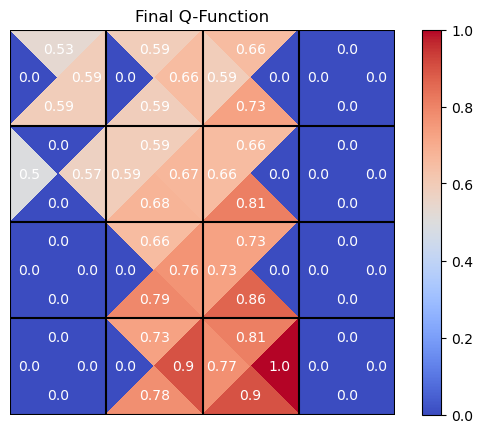

In [20]:
def evaluate(self, env, file, num_runs=5):
    """ Evaluates the agent in the environment.

    Args:
        env: Environment we want to use. 
        file: File used for storing the video.
        num_runs: Number of runs displayed
    """
    frames = []  # collect rgb_image of agent env interaction
    video_created = False
    for _ in range(num_runs):
        done = False
        obs, info = env.reset()
        out = env.render()
        frames.append(out)
        while not done:
            action = self.get_action(self.target_policy, obs)
            obs, reward, done, truncated, info = env.step(action)
            out = env.render()
            frames.append(out)
    # create animation out of saved frames
    if all(frame is not None for frame in frames):
        fig = plt.figure(figsize=(10, 6))
        plt.axis('off')
        img = plt.imshow(frames[0])
        def animate(index):
            img.set_data(frames[index])
            return [img]
        anim = FuncAnimation(fig, animate, frames=len(frames), interval=20)
        plt.close()
        anim.save(file, writer="ffmpeg", fps=5) 
    return

setattr(Agent, 'evaluate', evaluate)
setattr(Agent, 'plot_action_value', plot_action_value)

map = ["SFFH", "FFFH", "HFFH", "HFFG"]
env = gym.make('CustomFrozenLake-v1', render_mode='rgb_array', desc=map, is_slippery=False) 
env.reset()
agent = Agent(env, gamma=0.9)
agent.train(num_episodes=5000)
agent.plot_action_value()
video = "final_run.mp4"
agent.evaluate(env, video, num_runs=5)
Video(video, html_attributes="loop autoplay")

In [ ]:
# This is the end of task 3.

In [23]:
# another case : num_runs = 20



# def evaluate(self, env, file, num_runs=5):
#     """ Evaluates the agent in the environment.

#     Args:
#         env: Environment we want to use. 
#         file: File used for storing the video.
#         num_runs: Number of runs displayed
#     """
#     frames = []  # collect rgb_image of agent env interaction
#     video_created = False
#     for _ in range(num_runs):
#         done = False
#         obs, info = env.reset()
#         out = env.render()
#         frames.append(out)
#         while not done:
#             action = self.get_action(self.target_policy, obs)
#             obs, reward, done, truncated, info = env.step(action)
#             out = env.render()
#             frames.append(out)
#     # create animation out of saved frames
#     if all(frame is not None for frame in frames):
#         fig = plt.figure(figsize=(10, 6))
#         plt.axis('off')
#         img = plt.imshow(frames[0])
#         def animate(index):
#             img.set_data(frames[index])
#             return [img]
#         anim = FuncAnimation(fig, animate, frames=len(frames), interval=20)
#         plt.close()
#         anim.save(file, writer="ffmpeg", fps=5) 
#     return

# setattr(Agent, 'evaluate', evaluate)
# setattr(Agent, 'plot_action_value', plot_action_value)

# map = ["SFFH", "FFFH", "HFFH", "HFFG"]
# env = gym.make('CustomFrozenLake-v1', render_mode='rgb_array', desc=map, is_slippery=False) 
# env.reset()
# agent = Agent(env, gamma=0.9)
# agent.train(num_episodes=5000)
# agent.plot_action_value()
# video = "final_run.mp4"
# agent.evaluate(env, video, num_runs=20)
# Video(video, html_attributes="loop autoplay")